In [1]:
import torch
import torch.nn.functional as F


In [2]:

class Masks:
    def __init__(self, mask):
        mtype = mask.dtype
        self.q = mask.reshape((1,)*(4-len(mask.shape)) + mask.shape)
        self.u = F.avg_pool2d(self.q, (2,1), stride=(1,1), padding=(1,0)) > 3/4
        self.v = F.avg_pool2d(self.q, (1,2), stride=(1,1), padding=(0,1)) > 3/4
        self.psi = F.avg_pool2d(self.q, (2,2), stride=(1,1), padding=(1,1)) > 7/8

        self.not_q = torch.logical_not(self.q.type(torch.bool))
        self.not_u = torch.logical_not(self.u)
        self.not_v = torch.logical_not(self.v)
        self.not_psi = torch.logical_not(self.psi)

        self.psi_irrbound_xids, self.psi_irrbound_yids = torch.where(
                torch.logical_and(self.not_psi[0,0,1:-1,1:-1],
                F.avg_pool2d(self.psi.type(mtype), (3,3), stride=(1,1))[0,0] > 1/18)
            )

        self.q_distbound1 = torch.logical_and(
            F.avg_pool2d(self.q.type(mtype), (3,3), stride=(1,1), padding=(1,1)) < 17/18,
            self.q)

        self.u_distbound1 = torch.logical_and(
            F.avg_pool2d(self.u.type(mtype), (3,1), stride=(1,1), padding=(1,0)) < 5/6,
            self.u)
        self.u_distbound2plus = torch.logical_and(
            torch.logical_not(self.u_distbound1), self.u)
        self.u_distbound2 = torch.logical_and(
            F.avg_pool2d(self.u.type(mtype), (5,1), stride=(1,1), padding=(2,0)) < 9/10,
            self.u_distbound2plus)
        self.u_distbound3plus = torch.logical_and(
            torch.logical_not(self.u_distbound2), self.u_distbound2plus)

        self.v_distbound1 = torch.logical_and(
            F.avg_pool2d(self.v.type(mtype), (1,3), stride=(1,1), padding=(0,1)) < 5/6,
            self.v)
        self.v_distbound2plus = torch.logical_and(
            torch.logical_not(self.v_distbound1), self.v)
        self.v_distbound2 = torch.logical_and(
            F.avg_pool2d(self.v.type(mtype), (1,5), stride=(1,1), padding=(0,2)) < 9/10,
            self.v_distbound2plus)
        self.v_distbound3plus = torch.logical_and(
            torch.logical_not(self.v_distbound2), self.v_distbound2plus)


        self.q = self.q.type(mtype)
        self.u = self.u.type(mtype)
        self.v = self.v.type(mtype)
        self.psi = self.psi.type(mtype)
        self.not_q = self.not_q.type(mtype)
        self.not_u = self.not_u.type(mtype)
        self.not_v = self.not_v.type(mtype)
        self.not_psi = self.not_psi.type(mtype)

        self.q_distbound1 = self.q_distbound1.type(mtype)

        self.u_distbound1 = self.u_distbound1.type(mtype)
        self.u_distbound2 = self.u_distbound2.type(mtype)
        self.u_distbound2plus = self.u_distbound2plus.type(mtype)
        self.u_distbound3plus = self.u_distbound3plus.type(mtype)

        self.v_distbound1 = self.v_distbound1.type(mtype)
        self.v_distbound2 = self.v_distbound2.type(mtype)
        self.v_distbound2plus = self.v_distbound2plus.type(mtype)
        self.v_distbound3plus = self.v_distbound3plus.type(mtype)



[None, None, None, None, None, None, None]

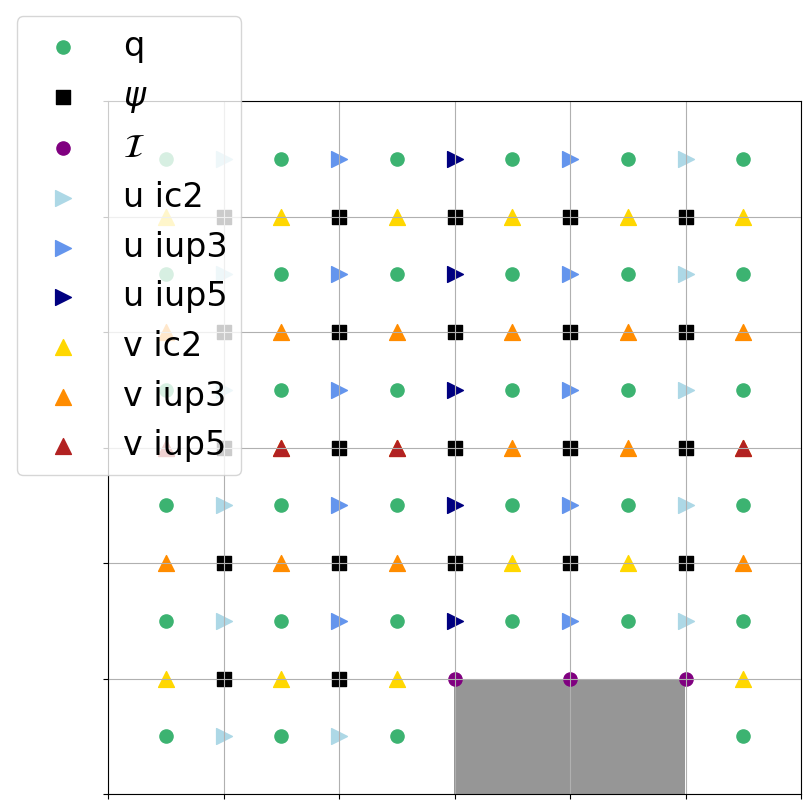

In [4]:

import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 24})
import matplotlib.pyplot as plt

n = 6
mask = torch.ones(n,n)
# mask[1,0] = 0.
# mask[n-1,2] = 0.
# mask[0,n-2] = 0.
# mask[1,n-2] = 0.
# mask[0,n-1] = 0.
# mask[1,n-1] = 0.
# mask[2,n-1] = 0.

mask[n//2:n//2+2,:n//4] = 0

masks = Masks(mask)

plt.ion()
f,a =plt.subplots(figsize=(9,9))
a.imshow(mask.T, origin='lower', cmap='Greys_r', interpolation=None, vmin=-1)
a.set_xticks(np.arange(-0.5,n+0.5)), a.set_yticks(np.arange(-0.5,n+0.5))
a.grid()

s = 90
s2 = 130
q_xmin, q_ymin = 0, 0
mask_q_ids = torch.argwhere(masks.q.squeeze())
a.scatter(q_xmin+mask_q_ids[:,0], q_ymin+mask_q_ids[:,1],
            s=s, marker='o', label='q', color='mediumseagreen')

psi_xmin, psi_ymin = -.5, -.5
mask_psi_ids = torch.argwhere(masks.psi.squeeze())
a.scatter(psi_xmin+mask_psi_ids[:,0], psi_ymin+mask_psi_ids[:,1],
          s=s, marker='s', label='$\\psi$', color='black')
a.scatter(psi_xmin+1+masks.psi_irrbound_xids,psi_ymin+1+masks.psi_irrbound_yids,
          s=s, marker='o', label='$\mathcal{I}$', color='purple')

u_xmin, u_ymin = -.5, 0
mask_u_ids = torch.argwhere(masks.u_distbound1.squeeze())
a.scatter(u_xmin+mask_u_ids[:,0], u_ymin+mask_u_ids[:,1],
            s=s2, marker='>', label='u ic2', color='lightblue')
mask_u_ids = torch.argwhere(masks.u_distbound2.squeeze())
a.scatter(u_xmin+mask_u_ids[:,0], u_ymin+mask_u_ids[:,1],
            s=s2, marker='>', label='u iup3', color='cornflowerblue')
mask_u_ids = torch.argwhere(masks.u_distbound3plus.squeeze())
a.scatter(u_xmin+mask_u_ids[:,0], u_ymin+mask_u_ids[:,1],
            s=s2, marker='>', label='u iup5', color='navy')

v_xmin, v_ymin = 0, -.5
mask_v_ids = torch.argwhere(masks.v_distbound1.squeeze())
a.scatter(v_xmin+mask_v_ids[:,0], v_ymin+mask_v_ids[:,1],
            s=s2, marker='^', label='v ic2', color='gold')
mask_v_ids = torch.argwhere(masks.v_distbound2plus.squeeze())
a.scatter(v_xmin+mask_v_ids[:,0], v_ymin+mask_v_ids[:,1],
            s=s2, marker='^', label='v iup3', color='darkorange')
mask_v_ids = torch.argwhere(masks.v_distbound3plus.squeeze())
a.scatter(v_xmin+mask_v_ids[:,0], v_ymin+mask_v_ids[:,1],
            s=s2, marker='^', label='v iup5', color='firebrick')



f.legend(loc='upper left')
plt.setp(a.get_xticklabels(), visible=False)
plt.setp(a.get_yticklabels(), visible=False)